In [58]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import sys
sys.path.append('../visualization')
sys.path.append('../acd/util')
sys.path.append('../acd/scores')
sys.path.append('../acd/agglomeration')
import agg_2d as agg
import viz_2d as viz
import tiling_2d as tiling
import cd
import score_funcs


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load the model and dset

In [2]:
# load the dataset
sys.path.append('../dsets/mnist')
import dset
from model import Net
im_torch, im_orig, label = dset.get_im_and_label(250, device=device) # this will download the mnist dataset


# load the model
model = Net().to(device)
model.load_state_dict(torch.load('../dsets/mnist/mnist.model', map_location=device))
model = model.eval()

# generate max act im

<Figure size 600x400 with 0 Axes>

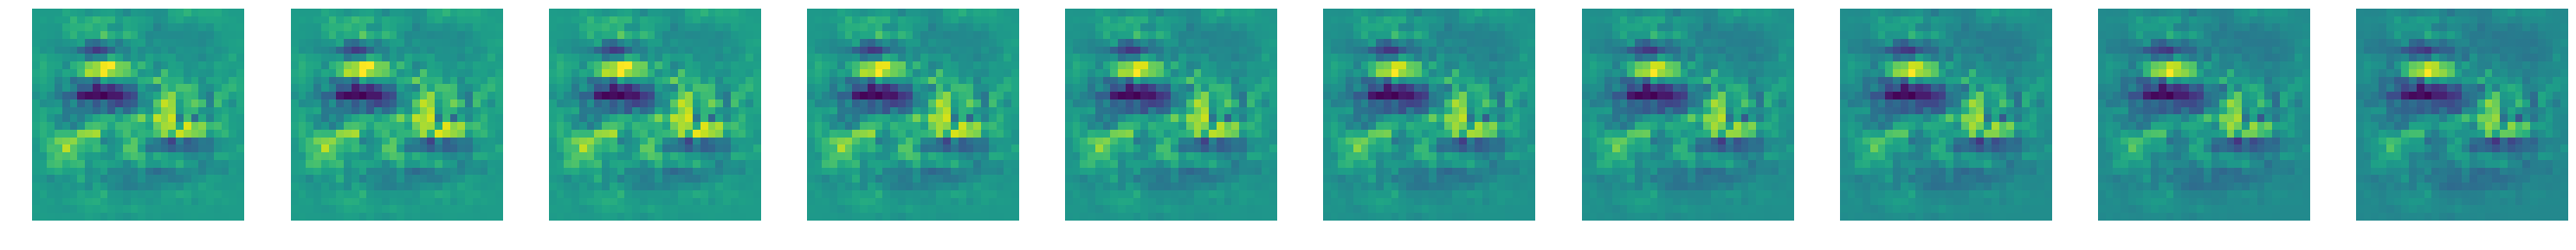

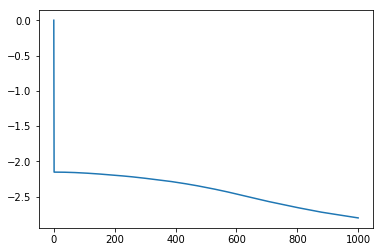

In [59]:
sys.path.append('../max_act')
from max_act import maximize_im, maximize_im_simple
import visualize_ims as viz_max

device = 'cuda'
model = model.to(device)
class_num = 5
im_shape = (1, 1, 28, 28) # (1, 3, 64, 64,
im = torch.zeros(im_shape, requires_grad=True, device=device)
ims_opt, losses = maximize_im_simple(model, im, class_num=class_num, lr=1e-5,
                                     num_iters=int(1e3), lambda_tv=1e-1, lambda_pnorm=1e-1)

viz_max.show(ims_opt[::2])
plt.show()

plt.plot(losses)
plt.show()

# score the max act im

100%|██████████| 784/784 [00:00<00:00, 1490.17it/s]


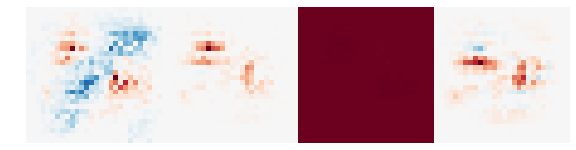

In [66]:
def get_diff_scores(im_torch, im_orig, label_num, model, preds, sweep_dim):
    scores = []

    # cd
    method = 'cd'
    tiles = tiling.gen_tiles(im_orig, fill=0, method=method, sweep_dim=sweep_dim)
    scores_cd = score_funcs.get_scores_2d(model, method=method, ims=tiles, 
                                   im_torch=im_torch, model_type=model_type, device=device)
    scores.append(scores_cd)
    for method in ['occlusion']: # 'build_up'
        tiles_break = tiling.gen_tiles(im_orig, fill=0, method=method, sweep_dim=sweep_dim)
        preds_break = score_funcs.get_scores_2d(model, method=method, ims=tiles_break, 
                                            im_torch=im_torch, pred_ims=dset.pred_ims)
        if method == 'occlusion':
            preds_break += preds
        scores.append(np.copy(preds_break))
    
    # get integrated gradients scores
    scores.append(score_funcs.ig_scores_2d(model, im_torch, num_classes=10, 
                                           im_size=28, sweep_dim=sweep_dim, ind=[label_num], device=device))
    
    return scores



# pick an image + get scores
# im_nums = [34, 20, 36, 32] # 34: screen, 20: snake, 36: trash can, 32: crane
sweep_dim = 1

model_type = 'mnist'
# sweep_dim = 56
fig = plt.figure(figsize=(10, 8), facecolor='white')

# for x, im_num in enumerate(im_nums):
im_torch = ims_opt[-1]
label_num = class_num
im_orig = ims_opt[-1].numpy().squeeze()
#im_torch, im_orig, label_num = dset.get_im_and_label(im_num, device=device) # this will download the mnist dataset

#     im_torch, im_orig, label_num = imnet_dict[im_num] # remember torch is H x W x C
#     print('lab', dset.lab_dict[label_num])
# viz.visualize_ims_tiled(tiling.gen_tiles(im_orig, fill=np.nan))
preds = dset.pred_ims(model, im_orig).flatten()
ind = np.argpartition(preds, -8)[-8:] # top-scoring indexes
ind = ind[np.argsort(preds[ind])][::-1] # sort the indexes
scores = get_diff_scores(im_torch, im_orig, label_num, model, preds, sweep_dim)

# plot raw image
num_rows = 1
num_cols = len(scores) + 1

# plot scores
vmax = max([np.max(scores[i]) for i in range(len(scores))])
vmin = min([np.min(scores[i]) for i in range(len(scores))])
vabs = max(abs(vmax), abs(vmin))
for i, tit in enumerate(['CD', 'Occlusion', 'IG']):
    plt.subplot(num_rows, num_cols, i + 1)
    if i == 0:
        plt.ylabel('pred: ' + str(ind[0]) + '...', fontsize=15)     
    p = viz.visualize_preds(scores[i], num=label_num, cbar=False) #axis_off=False,  vabs=vabs)
    plt.title(tit)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()